In [153]:
!pip install graphviz

In [154]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from reader import generic_reader
import seaborn as sns
import os
import ast
os.environ["PATH"] += r";C:\Program Files\Graphviz\bin"
import graphviz

In [155]:
df_danish_actors = generic_reader.read_csv_file_to_data_frame("../movie_data/danish_actors.csv")
df_danish_movies = generic_reader.read_csv_file_to_data_frame("../movie_data/danish_movies.csv")

In [156]:
list(df_danish_movies)

['adult',
 'backdrop_path',
 'budget',
 'homepage',
 'id',
 'imdb_id',
 'origin_country',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count',
 'genre_ids',
 'production_company_ids',
 'collection_id',
 'cast_person_ids',
 'cast_credit_ids',
 'crew_person_ids',
 'crew_credit_ids']

In [157]:
print(df_danish_actors.columns)

Index(['actor_id', 'movie_ids', 'adult', 'also_known_as', 'biography',
       'birthday', 'deathday', 'gender', 'homepage', 'imdb_id',
       'known_for_department', 'name', 'place_of_birth', 'popularity',
       'profile_path'],
      dtype='object')


In [158]:
# Dropping columns which won't be needed
columns_to_drop = ['name', 'adult', 'also_known_as', 'biography', 'deathday', 
                   'homepage', 'imdb_id', 'known_for_department', 'place_of_birth', 'profile_path']

df_clean_actors = df_danish_actors.drop(columns=columns_to_drop)

# Convert birthday to datetime
df_clean_actors['birthday'] = pd.to_datetime(
    df_clean_actors['birthday'], errors='coerce'
)

# Calculate age instead of birth_year
today = pd.Timestamp.today()
df_clean_actors['age'] = df_clean_actors['birthday'].apply(
    lambda d: (today.year - d.year) - (
        (today.month, today.day) < (d.month, d.day)
    ) if pd.notnull(d) else None
)

# Count number of movies in movie_ids
df_clean_actors['movie_count'] = df_clean_actors['movie_ids'].apply(
    lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x)
)

print(df_clean_actors.head())

   actor_id                                          movie_ids   birthday  \
0        42  {658817, 456325, 29445, 1354636, 752908, 14460... 1956-04-30   
1        53                                            {15843} 1953-08-27   
2       169                                             {8883} 1947-06-18   
3       378                                           {266285} 1947-06-01   
4       380                                           {214137} 1943-08-17   

   gender  popularity   age  movie_count  
0       2      0.9635  69.0           23  
1       2      5.0311  72.0            1  
2       2      0.2330  78.0            1  
3       2      2.1896  78.0            1  
4       2      3.2940  82.0            1  


In [159]:
df_clean_actors.shape

(15602, 7)

In [160]:
num_rows = (df_clean_actors["movie_count"] <= 2).sum()
print(num_rows)


12909


In [161]:
df_danish_movies.dtypes

adult                        bool
backdrop_path              object
budget                      int64
homepage                   object
id                          int64
imdb_id                    object
origin_country             object
original_language          object
original_title             object
overview                   object
popularity                float64
poster_path                object
production_countries       object
release_date               object
revenue                     int64
runtime                     int64
spoken_languages           object
status                     object
tagline                    object
title                      object
video                        bool
vote_average              float64
vote_count                  int64
genre_ids                  object
production_company_ids     object
collection_id             float64
cast_person_ids            object
cast_credit_ids            object
crew_person_ids            object
crew_credit_id

In [162]:
print(df_danish_movies.columns)

Index(['adult', 'backdrop_path', 'budget', 'homepage', 'id', 'imdb_id',
       'origin_country', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'genre_ids',
       'production_company_ids', 'collection_id', 'cast_person_ids',
       'cast_credit_ids', 'crew_person_ids', 'crew_credit_ids'],
      dtype='object')


In [163]:
# Droppping columns which won't be neeeded
columns_to_drop = ['adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'origin_country',
                   'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_countries', 'revenue',
                   'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'genre_ids',
                   'production_company_ids', 'collection_id', 'crew_person_ids', 'crew_credit_ids', 'cast_credit_ids']
df_clean_movies = df_danish_movies.drop(columns=columns_to_drop)

# Convert string representation of sets to actual lists
df_clean_movies['cast_person_ids'] = df_clean_movies['cast_person_ids'].apply(
    lambda x: list(ast.literal_eval(x)) if isinstance(x, str) else (list(x) if pd.notna(x) else [])
)

# Explode to one row per actor per movie
df_clean_movies = df_clean_movies.explode('cast_person_ids')

# Drop rows with missing actor_id
df_clean_movies = df_clean_movies.dropna(subset=['cast_person_ids'])

# Rename and convert actor_id
df_clean_movies = df_clean_movies.rename(columns={'cast_person_ids': 'actor_id'})
df_clean_movies['actor_id'] = df_clean_movies['actor_id'].astype(int)

# Convert release_date to datetime
df_clean_movies['release_date'] = pd.to_datetime(df_clean_movies['release_date'], errors='coerce')

# Reset index and drop duplicate actor/movie pairs
df_clean_movies = df_clean_movies.reset_index(drop=True)
df_clean_movies = df_clean_movies.drop_duplicates(subset=['id', 'actor_id'])


print(df_clean_movies.head())
print(f"Number of rows after exploding: {len(df_clean_movies)}")


        id release_date  vote_average  vote_count  actor_id
0   195139   1897-01-01           5.3          15   2452695
1   195364   1899-05-20           4.0           5   4658231
2   195364   1899-05-20           4.0           5   4658234
3   231776   1900-06-04           4.3           3   5301277
4  1188759   1902-02-02           0.0           0   1362101
Number of rows after exploding: 44325


In [164]:
df_clean_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44325 entries, 0 to 44368
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            44325 non-null  int64         
 1   release_date  44325 non-null  datetime64[ns]
 2   vote_average  44325 non-null  float64       
 3   vote_count    44325 non-null  int64         
 4   actor_id      44325 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.0 MB


In [165]:
df_clean_actors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15602 entries, 0 to 15601
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   actor_id     15602 non-null  int64         
 1   movie_ids    15602 non-null  object        
 2   birthday     4257 non-null   datetime64[ns]
 3   gender       15602 non-null  int64         
 4   popularity   15602 non-null  float64       
 5   age          4257 non-null   float64       
 6   movie_count  15602 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 853.4+ KB


In [166]:
"""# Merge actors and movies on movie_id / id
df_merged = pd.merge(
    df_clean_actors,
    df_clean_movies.drop(columns=['actor_id']),  # drop actor_id from movies to keep only actor's version
    left_on='movie_id',
    right_on='id',
    how='inner'
)

# Drop the redundant 'id' column from movies
df_merged = df_merged.drop(columns=['id'])

# Reset index
df_merged = df_merged.reset_index(drop=True)

print(df_merged.info())
print(df_merged.head())"""

"# Merge actors and movies on movie_id / id\ndf_merged = pd.merge(\n    df_clean_actors,\n    df_clean_movies.drop(columns=['actor_id']),  # drop actor_id from movies to keep only actor's version\n    left_on='movie_id',\n    right_on='id',\n    how='inner'\n)\n\n# Drop the redundant 'id' column from movies\ndf_merged = df_merged.drop(columns=['id'])\n\n# Reset index\ndf_merged = df_merged.reset_index(drop=True)\n\nprint(df_merged.info())\nprint(df_merged.head())"

In [167]:
#df_merged.isnull().sum()

In [168]:
#df_merged.shape

In [169]:
array = df_clean_actors.values

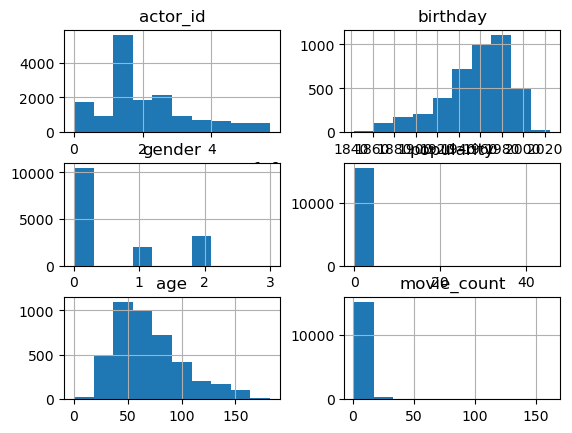

In [170]:
df_clean_actors.hist()
plt.show()

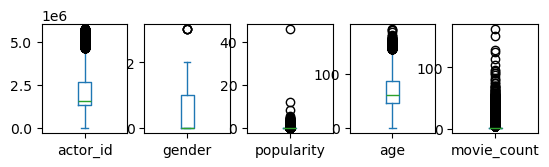

In [171]:
df_clean_actors.plot(kind='box', subplots=True, layout=(3,5), sharex=False, sharey=False)
plt.show()

In [172]:
feature_cols = [
    'age',          
    'movie_count' 
]
label_col = 'gender' 

In [173]:
array = df_clean_actors[feature_cols + [label_col]].dropna().values

In [174]:
X, y = array[:, :-1], array[:, -1]

In [175]:

female = X[y == 1] 
male = X[y == 2]   

In [176]:
set_prop = 0.20

In [177]:
seed = 12

In [178]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=set_prop, random_state=seed)

In [179]:
params = {'max_depth': 5}
classifier = DecisionTreeClassifier(**params)
randomclassifier = RandomForestClassifier(n_estimators = 100, max_depth = 4)

In [180]:
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [181]:
dot_data = tree.export_graphviz(
    classifier,
    out_file=None,
    feature_names=feature_cols,
    class_names=['', 'female', 'male'],  # '' for index 0
    filled=True, rounded=True
)

In [182]:
graph = graphviz.Source(dot_data)
graph.render("danish_actor")

'danish_actor.pdf'

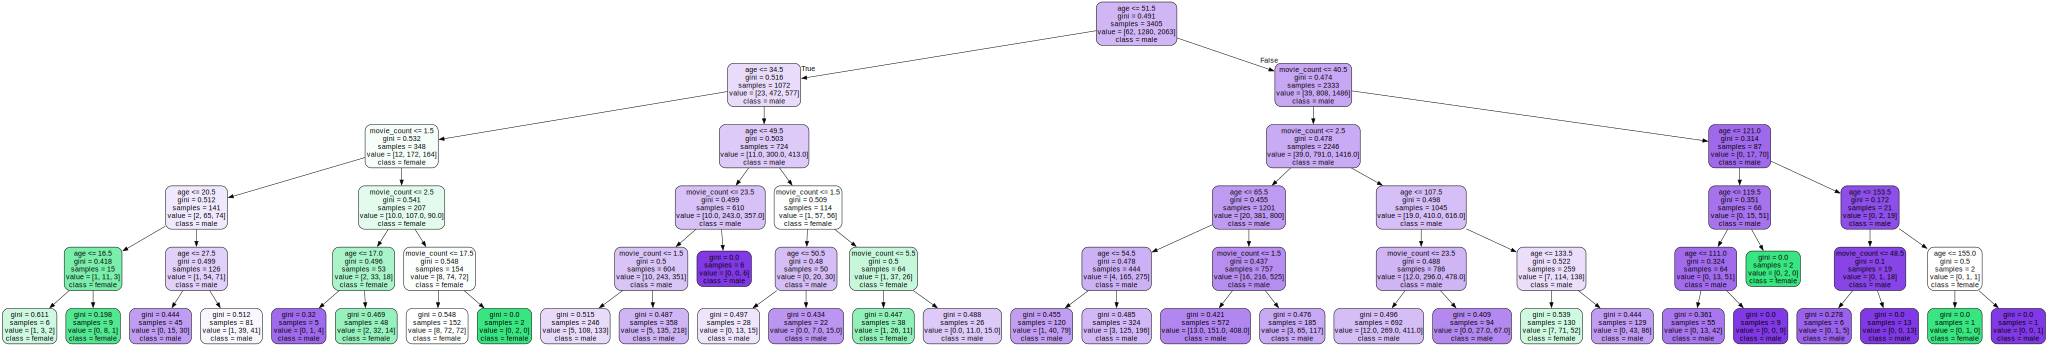

In [183]:
graph

In [184]:
scoring = 'accuracy'

In [185]:
y_testp = classifier.predict(X_test)
y_testp

array([1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2.,
       2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2.,
       1., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 1., 2., 2., 2., 2., 2.,
       2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2.,
       2., 1., 2., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 1., 2., 2.,
       1., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [186]:
y_test

array([2., 1., 1., 1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
       2., 2., 1., 1., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 2., 2., 2.,
       2., 1., 2., 1., 1., 1., 2., 2., 2., 1., 2., 2., 2., 2., 1., 2., 1.,
       2., 2., 1., 1., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2., 1., 2.,
       1., 1., 2., 2., 1., 2., 2., 2., 1., 1., 1., 2., 2., 2., 1., 1., 2.,
       2., 2., 2., 2., 1., 2., 2., 1., 2., 1., 2., 2., 1., 2., 1., 1., 2.,
       1., 2., 0., 2., 1., 2., 2., 1., 2., 2., 2., 1., 1., 1., 2., 1., 1.,
       2., 2., 1., 2., 2., 2., 2., 2., 1., 2., 2., 2., 1., 1., 2., 2., 2.,
       1., 2., 2., 1., 1., 2., 2., 2., 1., 1., 1., 2., 2., 1., 1., 2., 1.,
       2., 2., 1., 2., 1., 2., 1., 2., 1., 1., 1., 2., 1., 2., 2., 2., 0.,
       1., 1., 2., 2., 2., 2., 2., 1., 1., 3., 2., 1., 2., 2., 1., 1., 2.,
       1., 1., 1., 2., 1., 2., 1., 1., 1., 2., 2., 1., 2., 2., 2., 1., 2.,
       1., 2., 1., 2., 2., 2., 2., 2., 1., 1., 2., 1., 2., 2., 2., 1., 2.,
       1., 2., 2., 2., 1.

In [187]:
print ("Accuracy is ", accuracy_score(y_test,y_testp))

Accuracy is  0.5727699530516432


In [188]:
confusion_mat = confusion_matrix(y_test,y_testp)
confusion_mat

array([[  0,   4,   8,   0],
       [  0,  35, 308,   0],
       [  0,  41, 453,   0],
       [  0,   2,   1,   0]])

In [189]:
confusion = pd.crosstab(y_test,y_testp)
confusion

col_0,1.0,2.0
row_0,,
0.0,4,8
1.0,35,308
2.0,41,453
3.0,2,1


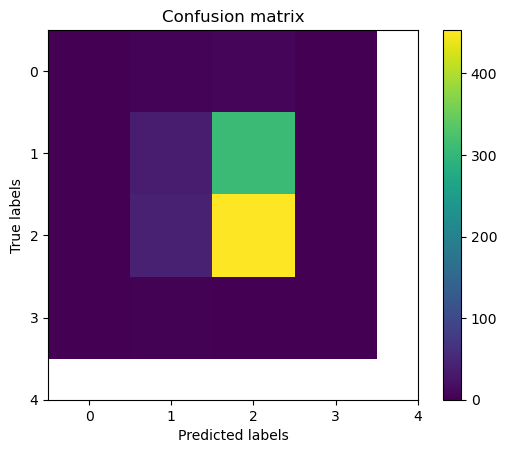

In [190]:
plt.imshow(confusion_mat, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(5)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

<Axes: >

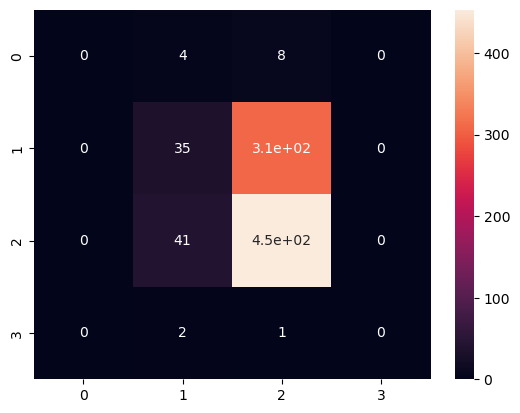

In [191]:
sns.heatmap(confusion_mat, annot=True)

In [192]:
randomclassifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=4)

In [ ]:
dot_data_random = tree.export_graphviz(
    randomclassifier,
    out_file=None,
    feature_names=feature_cols,
    class_names=['', 'female', 'male'],  # '' for index 0
    filled=True, rounded=True
)

In [194]:
graph_random = graphviz.Source(dot_data)
graph_random.render("danish_actor_random")

'danish_actor_random.pdf'

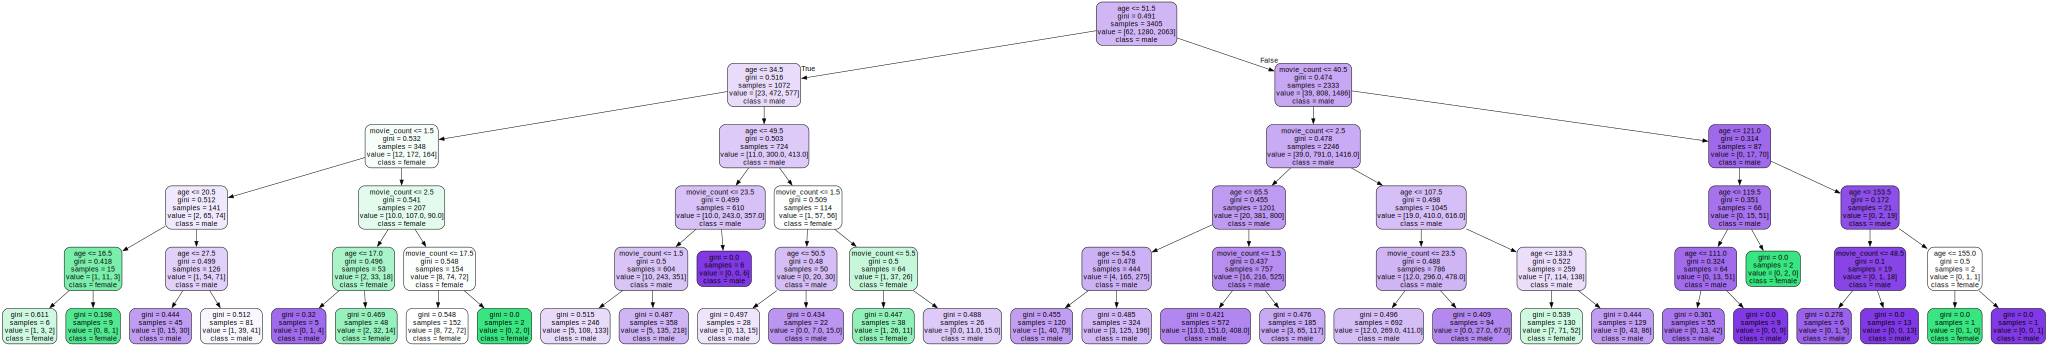

In [195]:
graph_random

In [196]:
scoring_random = 'accuracy'

In [197]:
y_testp = randomclassifier.predict(X_test)
y_testp

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 1., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [198]:
y_test

array([2., 1., 1., 1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
       2., 2., 1., 1., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 2., 2., 2.,
       2., 1., 2., 1., 1., 1., 2., 2., 2., 1., 2., 2., 2., 2., 1., 2., 1.,
       2., 2., 1., 1., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2., 1., 2.,
       1., 1., 2., 2., 1., 2., 2., 2., 1., 1., 1., 2., 2., 2., 1., 1., 2.,
       2., 2., 2., 2., 1., 2., 2., 1., 2., 1., 2., 2., 1., 2., 1., 1., 2.,
       1., 2., 0., 2., 1., 2., 2., 1., 2., 2., 2., 1., 1., 1., 2., 1., 1.,
       2., 2., 1., 2., 2., 2., 2., 2., 1., 2., 2., 2., 1., 1., 2., 2., 2.,
       1., 2., 2., 1., 1., 2., 2., 2., 1., 1., 1., 2., 2., 1., 1., 2., 1.,
       2., 2., 1., 2., 1., 2., 1., 2., 1., 1., 1., 2., 1., 2., 2., 2., 0.,
       1., 1., 2., 2., 2., 2., 2., 1., 1., 3., 2., 1., 2., 2., 1., 1., 2.,
       1., 1., 1., 2., 1., 2., 1., 1., 1., 2., 2., 1., 2., 2., 2., 1., 2.,
       1., 2., 1., 2., 2., 2., 2., 2., 1., 1., 2., 1., 2., 2., 2., 1., 2.,
       1., 2., 2., 2., 1.

In [199]:
print ("Accuracy is ", accuracy_score(y_test,y_testp))

Accuracy is  0.5762910798122066


In [200]:
confusion_mat_random = confusion_matrix(y_test,y_testp)
confusion_mat_random

array([[  0,   0,  12,   0],
       [  0,  11, 332,   0],
       [  0,  14, 480,   0],
       [  0,   2,   1,   0]])

In [201]:
confusion_random = pd.crosstab(y_test,y_testp)
confusion_random

col_0,1.0,2.0
row_0,,
0.0,0,12
1.0,11,332
2.0,14,480
3.0,2,1


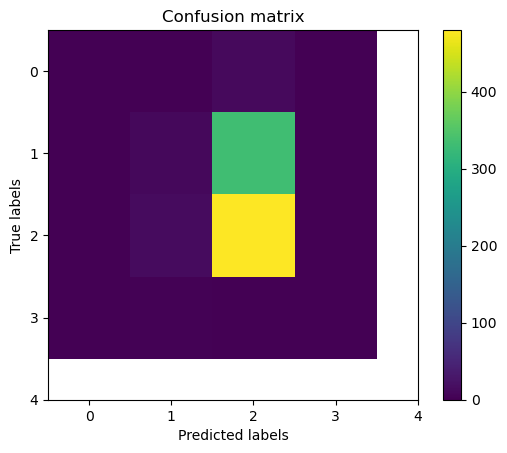

In [202]:
plt.imshow(confusion_mat_random, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(5)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

<Axes: >

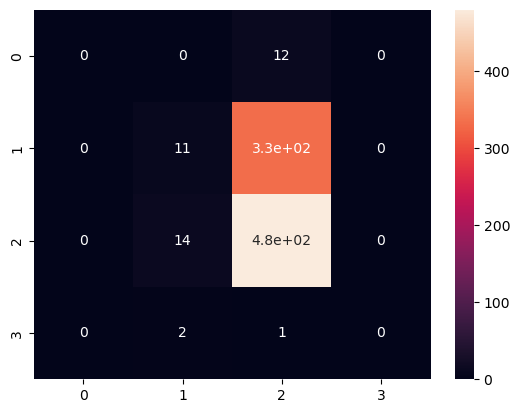

In [203]:
sns.heatmap(confusion_mat_random, annot=True)